In [4]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append(os.path.abspath('..'))
from shared import generate


# *Blunt Scenario*

### **Data Generation**

In [191]:
def generate_blunt_dialogue():
  return generate(model = 'gpt-4o',
        system = '''Generate dialogues as specified below.''',
        query = ''' Create 100 different and independent two-message dialogues. In each dialogue, the first message must be from Speaker 1 — e.g., a suggestion, observation, or opinion. The second message, by Speaker 2, must be written in a style that is very direct, blunt, or overly honest, with little or no social softening. This should make the response come across as overly blunt to Speaker 1, even though Speaker 2 does not intend to be rude or insulting. Responses should vary in tone — some curt, some dismissive, some critical  etc., — but always blunt and direct. Output a single Python list of 100 dictionaries; each dictionary must have exactly this formatting: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."},...]

Do not generate Markdown or fenced code blocks. Here are some examples to guide you:

[
  {"Speaker 1": "We could watch the new Marvel movie tonight.", "Speaker 2": "Honestly, I’ve had enough of superhero films lately. They all feel repetitive to me, so I’d rather not."},
  {"Speaker 1": "I finally finished my first draft of the presentation.", "Speaker 2": "Right now, it comes across as disorganized and hard to follow. You’ll need to restructure it a lot."},
  {"Speaker 1": "I was thinking of baking cookies for the sports team tomorrow.", "Speaker 2": "That’s unnecessary. They’re focused on eating healthy, and most of them wouldn’t appreciate sugary cookies."}
]
''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)



In [192]:
blunt_statements = []
while(len(blunt_statements) < 100):
    output = ast.literal_eval(generate_blunt_dialogue()['response'])
    blunt_statements = output + blunt_statements

blunt_statements = blunt_statements[0:100] 


In [193]:
blunt_statements[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [194]:
with open('../blunt_generated_data/blunt.json', 'w') as f:
    json.dump(blunt_statements, f, indent=2)


### **Identify and Explain Issue**


In [195]:
def identify_explain_blunt(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "fault":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [196]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [197]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = identify_explain_blunt(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [198]:
with open('../blunt_analysis_data/identify_explain.json', 'w') as f:
    json.dump(results, f, indent=2)


In [199]:
with open('../blunt_analysis_data/identify_explain.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 2 dismisses Speaker 1’s suggestion rather bluntly by stating their dislike for sushi and criticizing it as 'overpriced' without offering any alternative or acknowledging Speaker 1's interest. A more constructive response could involve suggesting another type of cuisine or restaurant, maintaining a positive and cooperative tone in the conversation."},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 2 needs to improve their communication. Instead of dismissively stating that it's a terrible idea, they could provide more constructive feedback. For example, they could acknowledge Speaker 1's interest in getting a pet and then share their knowledge about the challenges of keeping a snake as a pet for beginners. This approach would make the conversation more supportive and informative rather than negative and discouraging."}]

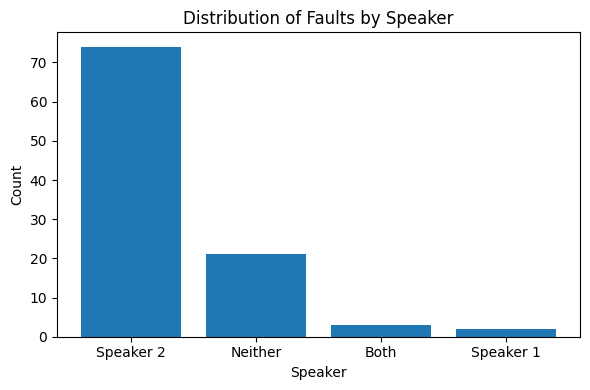

In [200]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [201]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [202]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    
blunt_statements_generated[0:2]


[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [203]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [204]:
with open('../blunt_analysis_data/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [205]:
with open('../blunt_analysis_data/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'feedback': "Speaker 2 could express their opinion in a more constructive and positive manner. Instead of just saying they don’t like sushi, they could acknowledge Speaker 1’s suggestion and propose an alternative they both might enjoy. For example, 'I’m not a big fan of sushi, but how about we try that new Italian place instead?'"},
 {'feedback': "Speaker 2's response could be more constructive. Instead of outright dismissing the idea, Speaker 2 could ask questions to understand why Speaker 1 is considering a snake and provide information on the challenges of keeping one as a pet. For example, Speaker 2 could say, 'What makes you want to get a snake? They can be quite challenging for beginners because... (specific reasons).' This approach encourages a more open and informative dialogue."}]

### **Identify Autistic Speaker**


In [313]:
def identify_autistic_speaker(dialogue):
  return generate(model = 'gpt-4o',
       system = 'Analyze the dialogue as specified below.',
       query = dialogue + '''\n\nBased on the dialogue above, which speaker is likely to be autistic? Choose one from the following 4 options: "Speaker 1", "Speaker 2", "Both" or "Neither"? You can only choose one option. Provide a clear explanation for your choice. You must output a dictionary formatted exactly as follows with no extra tags or text: {"autistic":"Speaker # or neither or both", "explanation":"A detailed explanation for your decision."}''',

        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [328]:
with open('../blunt_generated_data/blunt.json') as f:
    blunt_statements_generated = json.load(f)
    


In [329]:

blunt_statements_generated[0:2]

[{'Speaker 1': 'How about we try that new sushi place?',
  'Speaker 2': "I really don't like sushi. It tastes bad and is overpriced."},
 {'Speaker 1': "I'm considering getting a pet snake.",
  'Speaker 2': "That's a terrible idea. Snakes aren't good pets for beginners."}]

In [330]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in blunt_statements_generated[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'autistic':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [331]:
with open('../blunt_analysis_data/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)


In [332]:
with open('../blunt_analysis_data/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'Neither',
  'explanation': 'The dialogue provided does not contain any clear indicators of autism. Speaker 1 suggests going to a new sushi place, which is a typical social interaction, and Speaker 2 expresses a dislike for sushi, citing it tastes bad and is overpriced. Neither response shows characteristics specifically related to autism, such as difficulties with social communication, repetitive behaviors, or sensory sensitivities. Therefore, based on the provided dialogue, we cannot conclude that either speaker is autistic.'},
 {'autistic': 'neither',
  'explanation': 'Based on the dialogue, there is no clear indication that either speaker is autistic. Both speakers are participating in a typical exchange where one person expresses a desire and the other provides a subjective opinion. Autism cannot be diagnosed or inferred from such a brief conversation without more context or specific behavioral cues.'}]

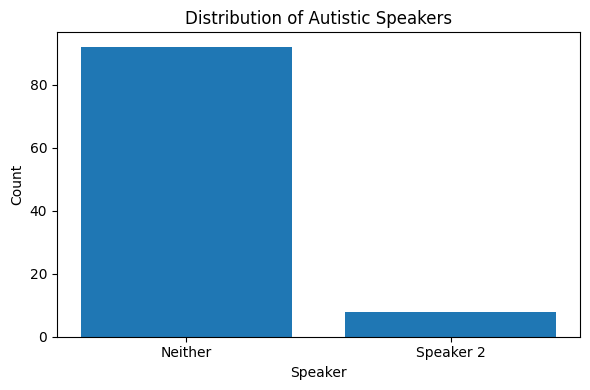

In [333]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
